In [48]:
from google.colab import files
import matplotlib.font_manager as fm

# 폰트 파일을 업로드
uploaded = files.upload()


# 추가할 폰트 파일 경로 설정 (상대경로 또는 절대경로 사용)
font_path = '/content/font/NanumGothic.ttf'  # 예시 폰트 경로

# 폰트 파일을 font_manager에 등록
fm.fontManager.addfont(font_path)

Saving NanumGothic.ttf to NanumGothic.ttf


In [49]:
# 새로 추가된 폰트 확인
font_prop = fm.FontProperties(fname=font_path)
print(font_prop.get_name())  # 폰트 이름 출력

NanumGothic


In [50]:
from matplotlib import rc
from matplotlib import font_manager, rc

# 업로드된 폰트 파일 경로 확인
font_path = '/content/font/NanumGothic.ttf'  # 업로드된 폰트 파일 경로
font_prop = font_manager.FontProperties(fname=font_path)
rc('font', family=font_prop.get_name())

In [51]:
import pandas as pd

data = pd.read_csv('sample_data/data_final')

In [52]:
import numpy as np

## 기본적인 정규화 및 pca 분석

In [53]:
from sklearn.preprocessing import StandardScaler

# 필요한 열만 선택
features = [
    '고도', '수용인원', 'earthquake_count', 'nearest_hospital_distance',
    '의원수', 'Convenience_Stores_within_300m', '반경 1km 산불 횟수', '연식_일'
]
data_selected = data[features]

# 결측치 처리 (결측치를 평균으로 대체)
data_cleaned = data_selected.fillna(data_selected.mean())

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# 정규화된 데이터를 확인
pd.DataFrame(data_scaled, columns=features).head()


,고도,수용인원,earthquake_count,nearest_hospital_distance,의원수,Convenience_Stores_within_300m,반경 1km 산불 횟수,연식_일
0,-0.145162,-0.206055,-0.621849,0.043663,0.866349,0.019333,-0.493493,0.644061
1,-0.211358,-0.379059,-0.621849,0.122012,-0.593326,-0.359278,-0.493493,-0.900676
2,-0.211358,-0.365648,-0.621849,0.149694,-0.593326,-0.359278,-0.493493,-0.902186
3,-0.211358,-0.378612,-0.621849,0.149694,-0.593326,-0.359278,-0.493493,-0.896900
4,-0.078966,-0.131399,-0.621849,-0.026319,-0.244747,0.776555,-0.493493,0.679555


In [54]:
from sklearn.decomposition import PCA
import numpy as np

# PCA 수행
pca = PCA(n_components=0.95)  # 95% 이상의 분산을 유지하도록 성분 선택
data_pca = pca.fit_transform(data_scaled)

# 결과 확인
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pd.DataFrame({
    'Principal Component': [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Variance': cumulative_variance
})

,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.266735,0.266735
1,PC2,0.200136,0.466871
2,PC3,0.156110,0.622981
3,PC4,0.124368,0.747349
4,PC5,0.110256,0.857605
5,PC6,0.076800,0.934405
6,PC7,0.041747,0.976153


## 주성분별 가중치 시각화

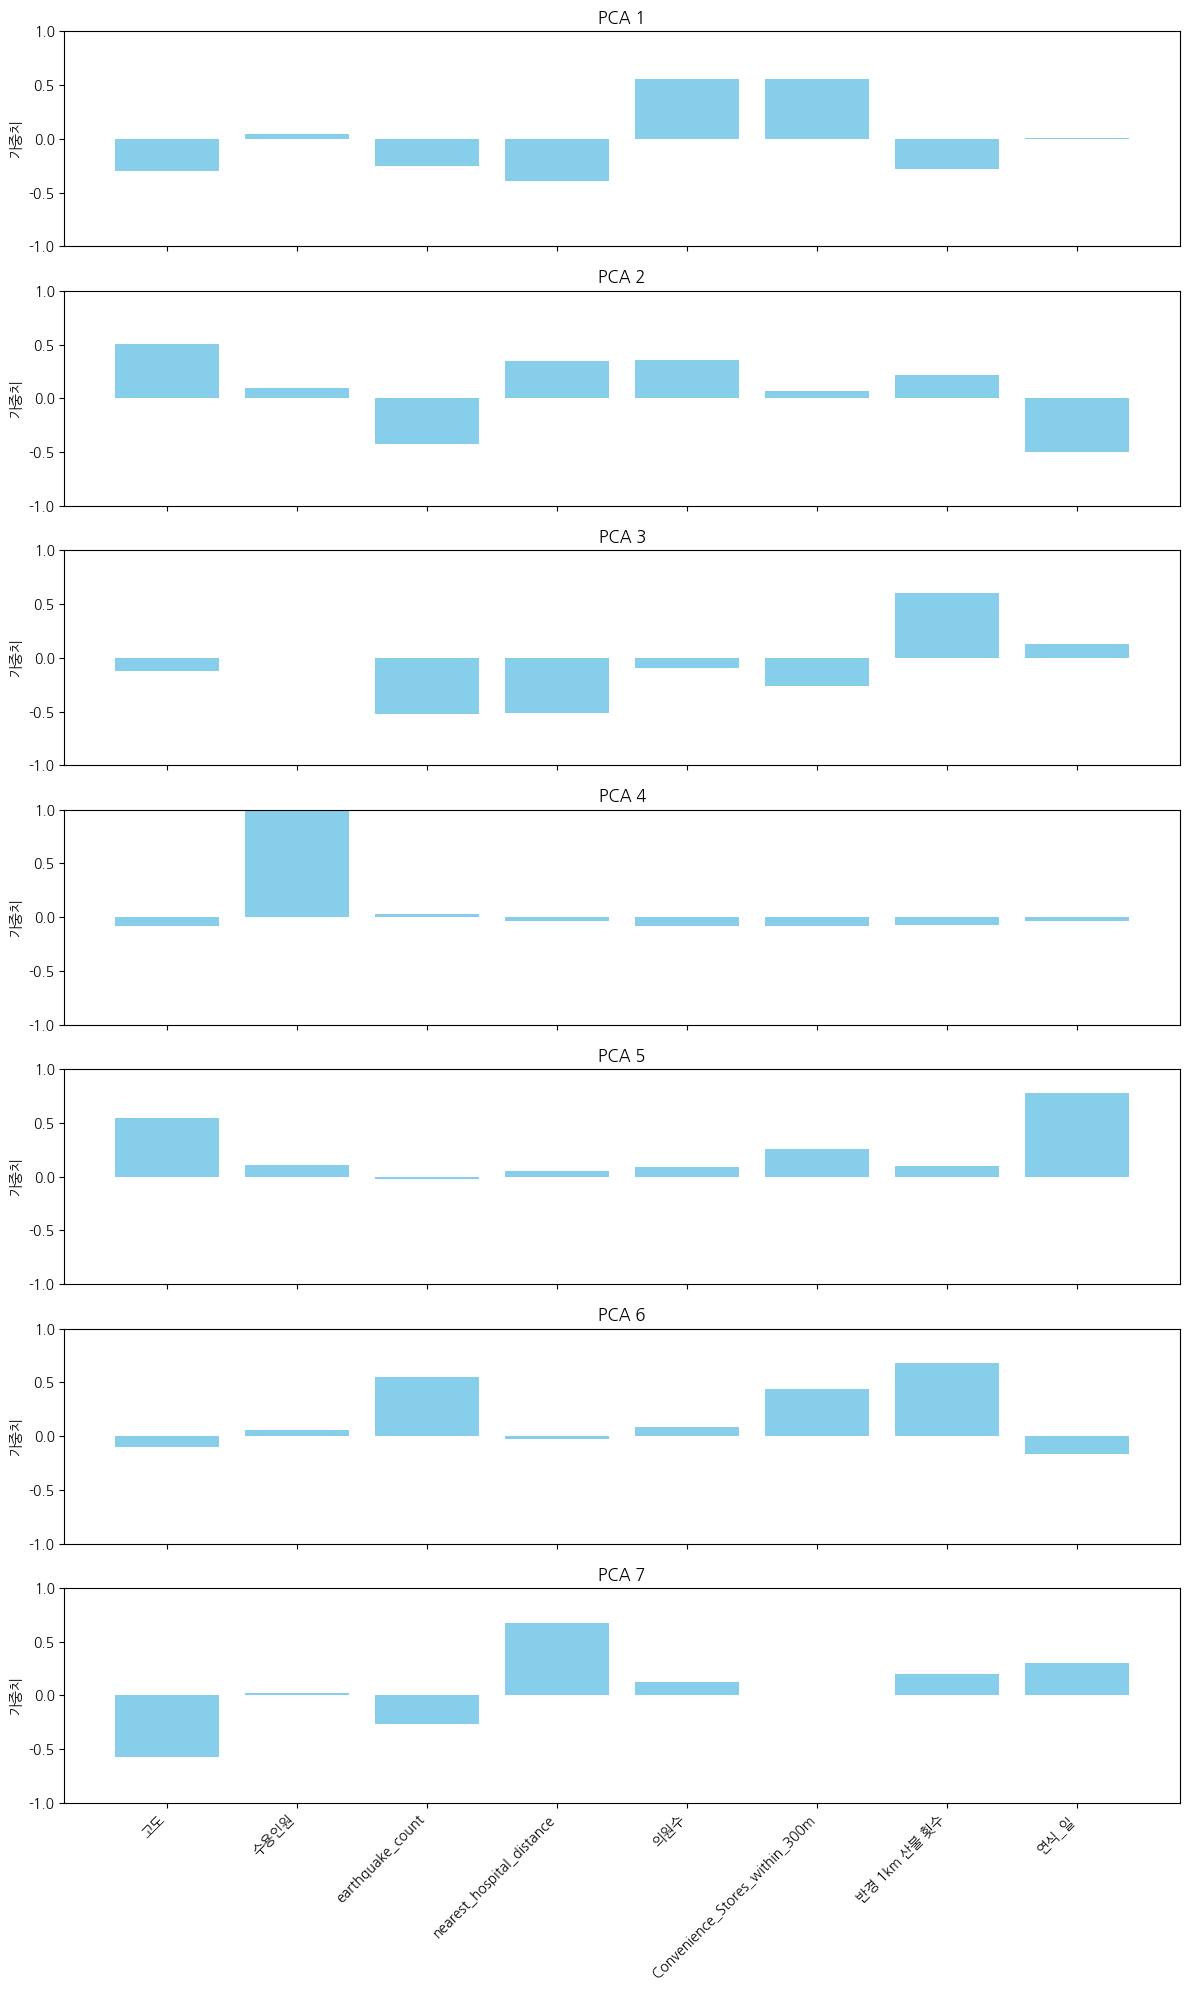

In [56]:
import matplotlib.pyplot as plt

# PCA의 주성분 계수(loading) 가져오기 다시 정의
loadings = pd.DataFrame(
    pca.components_,
    columns=features,
    index=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
)

# 각 주성분별 가중치(계수)를 막대그래프로 시각화 (수정된 버전)
fig, axes = plt.subplots(nrows=pca.components_.shape[0], figsize=(12, 20), sharex=True)

for i, ax in enumerate(axes):
    ax.bar(loadings.columns, loadings.iloc[i], color='skyblue')
    ax.set_title(f'PCA {i+1}')
    ax.set_ylabel('가중치')
    ax.set_ylim(-1, 1)

plt.xticks(rotation=45, ha='right')  # 기존 성분들의 이름을 X축에 표시
plt.tight_layout()
plt.show()

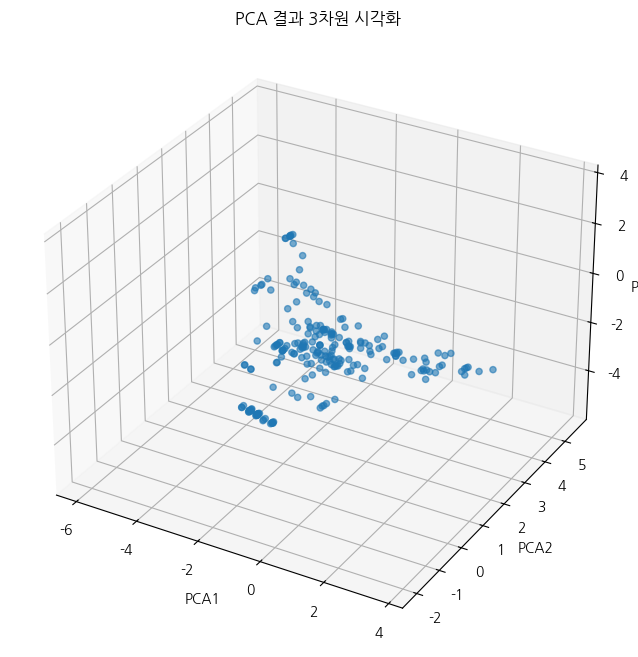

In [57]:
pca_columns = [f'PCA{i+1}' for i in range(7)]
data_pca_df = pd.DataFrame(data_pca, columns=pca_columns, index=data_cleaned.index)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca_df['PCA1'], data_pca_df['PCA2'], data_pca_df['PCA3'], alpha=0.6)
ax.set_title('PCA 결과 3차원 시각화')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

## HDBSCAN 실시(1차)

<b>min_cluster_size: 클러스터 당 최소데이터 포인터 개수</b>     

<b>min_samples:최소 이웃 포인터의 수</b>

Cluster
 2    112
-1     63
 0     37
 1     23
Name: count, dtype: int64


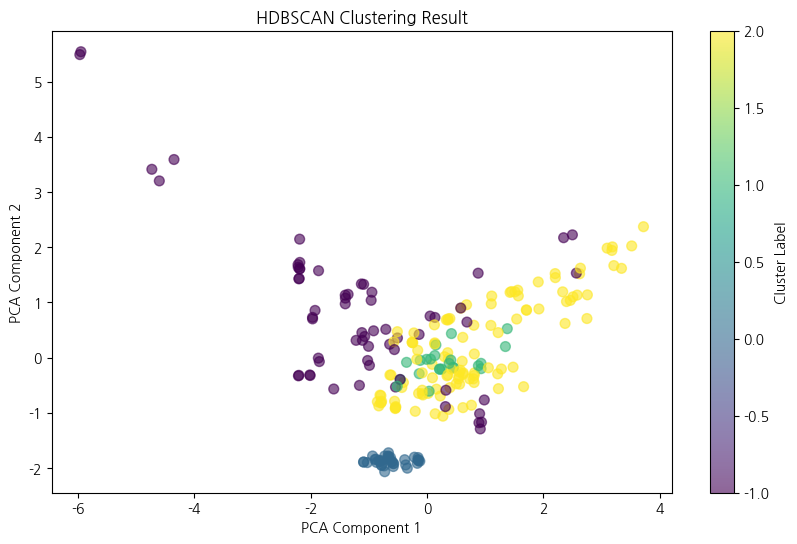

In [59]:
# 필요한 라이브러리 임포트
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 데이터 불러오기
data = pd.read_csv('sample_data/data_final')

# 필요한 열만 선택
features = [
    '고도', '수용인원', 'earthquake_count', 'nearest_hospital_distance',
    '의원수', 'Convenience_Stores_within_300m', '반경 1km 산불 횟수', '연식_일'
]
data_selected = data[features]

# 결측치 처리 (결측치를 평균으로 대체)
data_cleaned = data_selected.fillna(data_selected.mean())

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# PCA 수행
pca = PCA(n_components=0.95)  # 95% 이상의 분산을 유지하도록 성분 선택
data_pca = pca.fit_transform(data_scaled)

# HDBSCAN 클러스터링 수행
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
hdbscan_labels = hdbscan_model.fit_predict(data_pca)

# 클러스터링 결과를 원본 데이터에 추가
data['Cluster'] = hdbscan_labels

# 클러스터 분포 확인
cluster_counts = data['Cluster'].value_counts()
print(cluster_counts)

# 클러스터 결과 시각화C
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=hdbscan_labels, cmap='viridis', s=50, alpha=0.6)
plt.title('HDBSCAN Clustering Result')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


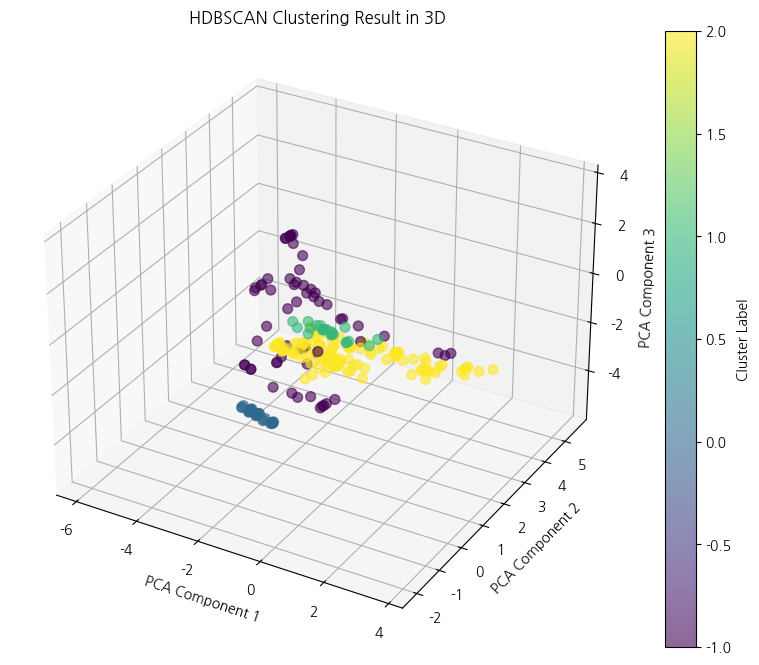

In [60]:
#7개의 차원을 쓰고 있으므로 최대 3차원에서 시각화

from mpl_toolkits.mplot3d import Axes3D

# 3차원 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=hdbscan_labels, cmap='viridis', s=50, alpha=0.6)
ax.set_title('HDBSCAN Clustering Result in 3D')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(sc, label='Cluster Label')
plt.show()


### 노이즈가 많으므로 수용인원에 대한 결측치 제거

Cluster
 2    84
-1    76
 0    40
 1    19
Name: count, dtype: int64


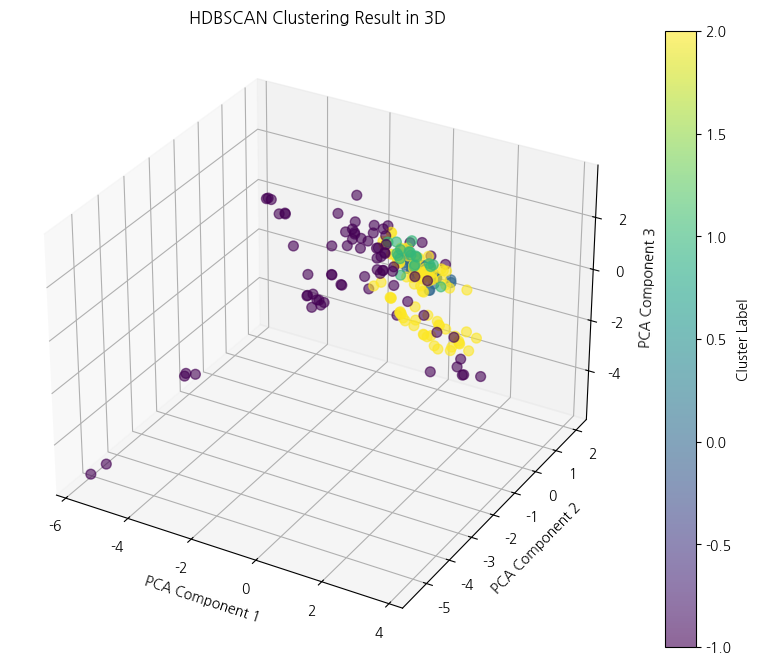

In [61]:
# 필요한 라이브러리 임포트
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 데이터 불러오기
data = pd.read_csv('sample_data/data_final')

# 필요한 열만 선택
features = [
    '고도', '수용인원', 'earthquake_count', 'nearest_hospital_distance',
    '의원수', 'Convenience_Stores_within_300m', '반경 1km 산불 횟수', '연식_일'
]
data_selected = data[features]

# 결측치 처리 (결측치를 평균으로 대체)
data_cleaned = data_selected.fillna(data_selected.mean())

# IQR을 사용하여 '수용인원'에서 이상치 제거
Q1 = data_cleaned['수용인원'].quantile(0.25)
Q3 = data_cleaned['수용인원'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_cleaned = data_cleaned[(data_cleaned['수용인원'] >= lower_bound) & (data_cleaned['수용인원'] <= upper_bound)]

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# PCA 수행
pca = PCA(n_components=7)  # 3개의 주성분으로 축소
data_pca = pca.fit_transform(data_scaled)



# HDBSCAN 클러스터링 수행
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
hdbscan_labels = hdbscan_model.fit_predict(data_pca)

# 클러스터링 결과를 원본 데이터에 추가
data_cleaned['Cluster'] = hdbscan_labels

# 클러스터 분포 확인
cluster_counts = data_cleaned['Cluster'].value_counts()
print(cluster_counts)

# 3차원 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=hdbscan_labels, cmap='viridis', s=50, alpha=0.6)
ax.set_title('HDBSCAN Clustering Result in 3D')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(sc, label='Cluster Label')
plt.show()


### cluster_selection_method='leaf'로 변경

eom: 기본값으로 가장 안정적인 클러스터를 선택

leaf:계층적 구조의 가장 하위 레벨 클러스터를 선택, eom으로 했을 때 클러스터가 잘 생성되지 않았고 데이터 구조가 복잡하므로 하위 레벨에서 클러스터링이 필요하다고 판단

Cluster
-1    93
 0    40
 3    37
 2    30
 1    19
Name: count, dtype: int64


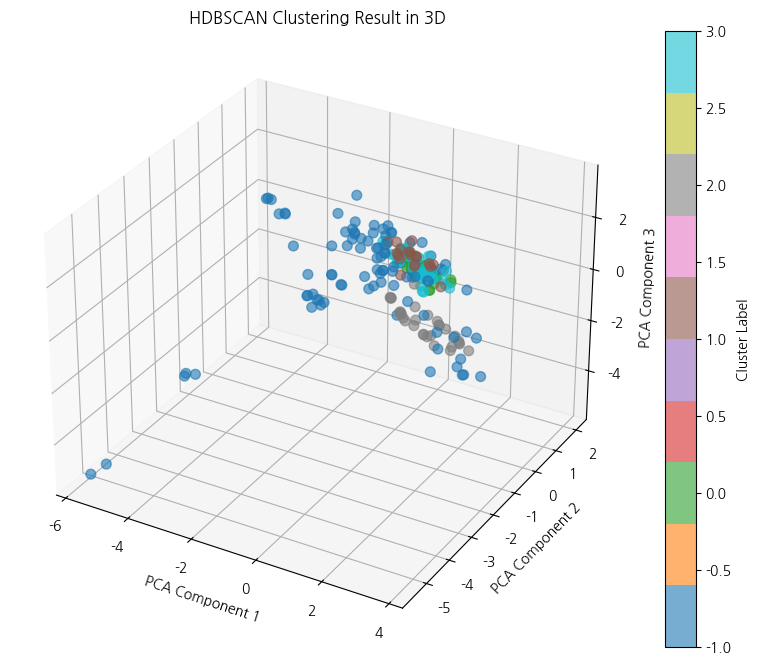

In [62]:

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean',cluster_selection_method='leaf')
hdbscan_labels = hdbscan_model.fit_predict(data_pca)

# 클러스터링 결과를 원본 데이터에 추가
data_cleaned['Cluster'] = hdbscan_labels

# 클러스터 분포 확인
cluster_counts = data_cleaned['Cluster'].value_counts()
print(cluster_counts)

# 3차원 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=hdbscan_labels, cmap='tab10', s=50, alpha=0.6)
ax.set_title('HDBSCAN Clustering Result in 3D')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(sc, label='Cluster Label')
plt.show()

## UMAP 차원축소 적용

1.  cluster_selection_method='leaf'로 변경해도 클러스터가 겹쳐서 생성됨
2. min_cluster_size, min_samples를 바꾸면서 클러스터링을 진행해도 비슷한 결과만 도출 됨
3. 현재 가지고 있는 데이터 특성 상, 이상치가 많을 수 밖에 없음(각 지역별로 발생한 지진,산불,주변 병원, 편의점의 편차가 큼, 하지만 이것들은 지역 특성이기 때문에 일방적으로 제거하거나, 평균값, 최빈값 등으로 대체하기 어렵다고 판단함)
3. 따라서 데이터를 다른 방식으로 변환할 필요를 느낌

### UMAP: 비성형차원축소법

- 국소적 및 전역적 구조를 모두 잘 보존하도록 설계됨
   -  우리가 가지고 있는 데이터 특성과 잘 부합한다고 판단함

- 고차원 공간의 데이터를 그래프 형태로 표현한 뒤, 이 그래프를 저차원 공간으로 투영하여 데이터의 구조를 보존함

기본 파라미터 사용(일반적으로 가장 잘 설명한다고 알려짐)
n_neighbors=15, min_dist=0.1

3차원 시각화하므로 3차원으로 차원 축소
 n_components=3


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Cluster
3    83
2    51
0    43
1    42
Name: count, dtype: int64


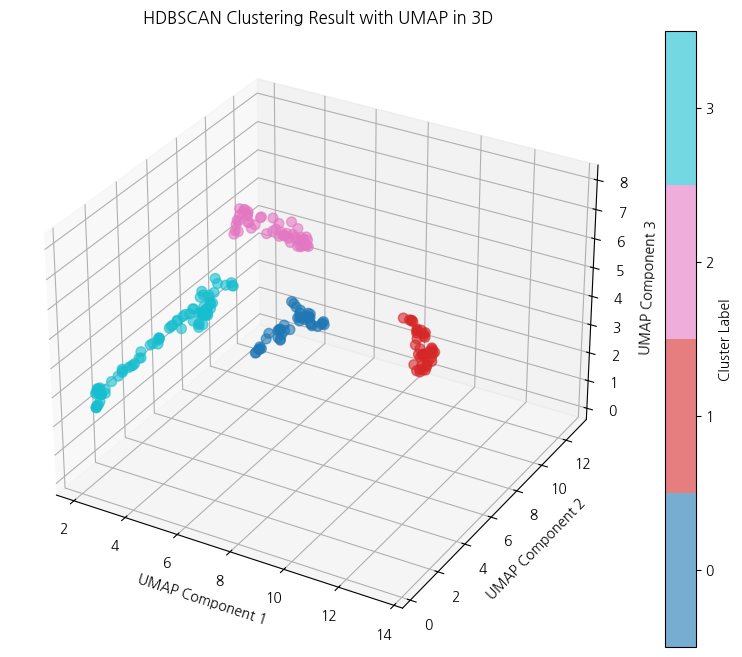

In [63]:
# 필요한 라이브러리 임포트
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from umap import UMAP
import numpy as np

# 데이터 불러오기
data = pd.read_csv('sample_data/data_final')

# 필요한 열만 선택
features = [
    '고도', '수용인원', 'earthquake_count', 'nearest_hospital_distance',
    '의원수', 'Convenience_Stores_within_300m', '반경 1km 산불 횟수', '연식_일'
]
data_selected = data[features]

# 결측치 처리 (결측치를 평균으로 대체)
data_cleaned = data_selected.fillna(data_selected.mean())

# IQR을 사용하여 '수용인원'에서 이상치 제거
Q1 = data_cleaned['수용인원'].quantile(0.25)
Q3 = data_cleaned['수용인원'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_cleaned = data_cleaned[(data_cleaned['수용인원'] >= lower_bound) & (data_cleaned['수용인원'] <= upper_bound)]

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# PCA 수행
pca = PCA(n_components=7)  # 7개의 주성분으로 축소
data_pca = pca.fit_transform(data_scaled)

# UMAP을 사용한 차원 축소
umap_reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
data_umap = umap_reducer.fit_transform(data_pca)

# HDBSCAN 클러스터링 수행
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean', cluster_selection_method='eom')
hdbscan_labels = hdbscan_model.fit_predict(data_umap)

# 클러스터링 결과를 원본 데이터에 추가
data_cleaned['Cluster'] = hdbscan_labels

# 클러스터 분포 확인
cluster_counts = data_cleaned['Cluster'].value_counts()
print(cluster_counts)

# UMAP을 이용한 3차원 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data_umap[:, 0], data_umap[:, 1], data_umap[:, 2], c=hdbscan_labels, cmap='tab10', s=50, alpha=0.6)
ax.set_title('HDBSCAN Clustering Result with UMAP in 3D')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
fig.colorbar(sc, label='Cluster Label', boundaries=[i-0.5 for i in range(len(set(hdbscan_labels)) + 1)], ticks=range(len(set(hdbscan_labels))))
plt.show()


### HDBSCAN 파라미터 조정

ERICH SCHUBERT 외 4명, DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN, 2017 참고

minPts: 데이터의 차원의 두 배 값으로 설정, 현재 PCA로 줄인 7개의 차원을 사용하고 있으므로 14로 지정

min_cluster_size: k-거리 그래프 활용, 각 데이터의 k-최근접 이웃 거리를 계산하고, 모든 포인트의 k-거리를 내림차순으로 정렬하여 플롯을 그려볼 수 있음. 이 그래프에서 꺾이는 지점을 찾으면 적절한 ε 값을 설정

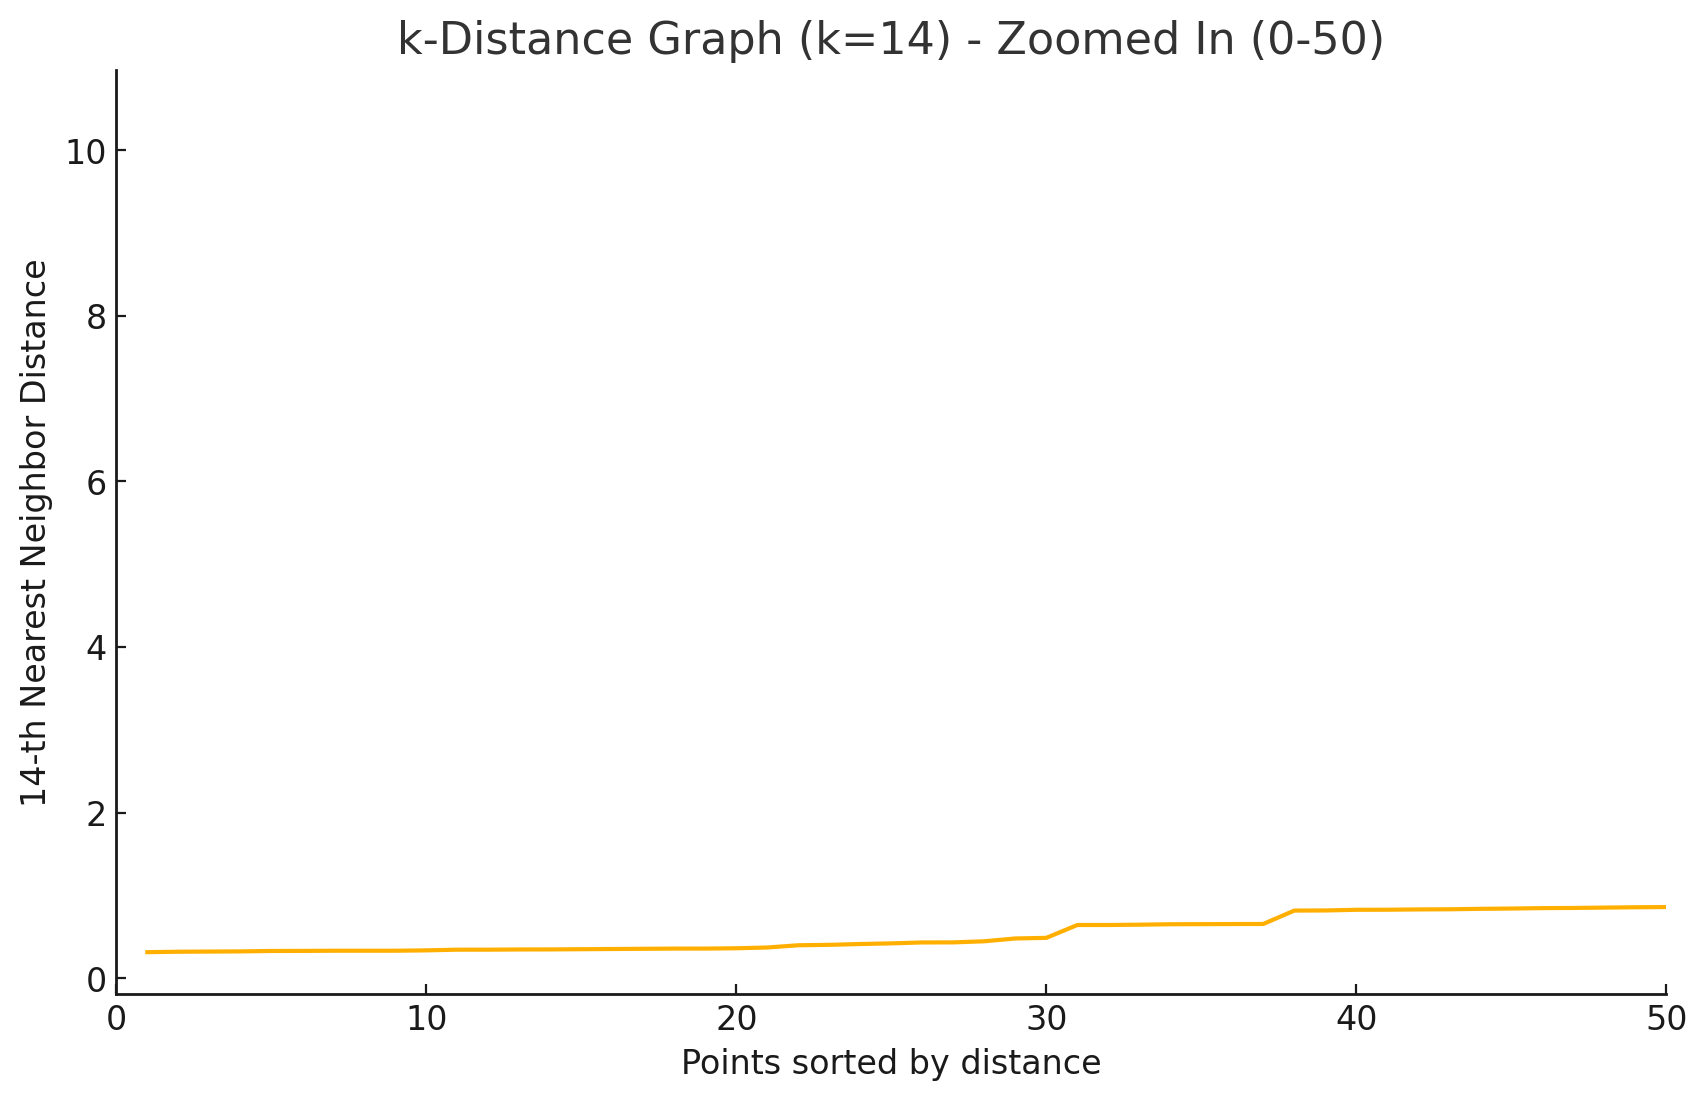
→ 가장 많이 꺾인 30으로 설정

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Cluster
 3    83
 2    51
 0    43
 1    42
-1    16
Name: count, dtype: int64


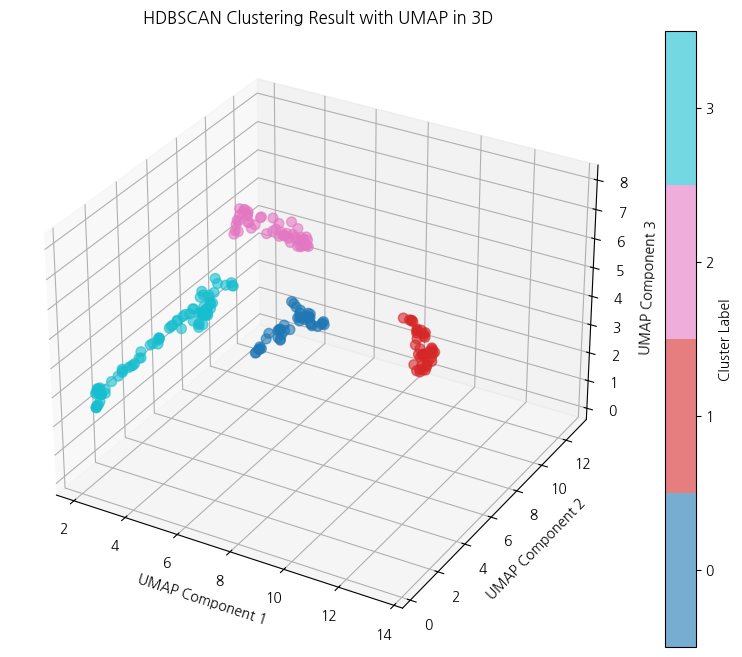

In [64]:
# 필요한 라이브러리 임포트
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
import numpy as np

# 데이터 불러오기
data = pd.read_csv('sample_data/data_final')

# 필요한 열만 선택
features = [
    '고도', '수용인원', 'earthquake_count', 'nearest_hospital_distance',
    '의원수', 'Convenience_Stores_within_300m', '반경 1km 산불 횟수', '연식_일'
]
data_selected = data[features]

# 결측치 처리 (결측치를 평균으로 대체)
data_cleaned = data_selected.fillna(data_selected.mean())

# IQR을 사용하여 '수용인원'에서 이상치 제거
Q1 = data_cleaned['수용인원'].quantile(0.25)
Q3 = data_cleaned['수용인원'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_cleaned = data_cleaned[(data_cleaned['수용인원'] >= lower_bound) & (data_cleaned['수용인원'] <= upper_bound)]

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# PCA 수행
pca = PCA(n_components=7)  # 7개의 주성분으로 축소
data_pca = pca.fit_transform(data_scaled)

# UMAP을 사용한 차원 축소
umap_reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
data_umap = umap_reducer.fit_transform(data_pca)

# HDBSCAN 클러스터링 수행
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=14, metric='euclidean', cluster_selection_method='eom')
hdbscan_labels = hdbscan_model.fit_predict(data_umap)

# 클러스터링 결과를 원본 데이터에 추가
data['Cluster'] = -1  # 기본 클러스터 값은 -1로 설정 (노이즈 포함)
data.loc[data_cleaned.index, 'Cluster'] = hdbscan_labels  # 클러스터 결과 추가

# 클러스터 분포 확인
cluster_counts = data['Cluster'].value_counts()
print(cluster_counts)

# UMAP을 이용한 3차원 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data_umap[:, 0], data_umap[:, 1], data_umap[:, 2], c=hdbscan_labels, cmap='tab10', s=50, alpha=0.6)
ax.set_title('HDBSCAN Clustering Result with UMAP in 3D')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
fig.colorbar(sc, label='Cluster Label', boundaries=[i-0.5 for i in range(len(set(hdbscan_labels)) + 1)], ticks=range(len(set(hdbscan_labels))))
plt.show()



### 멤버십 확률

각 포인트가 해당 클러스터의 밀도 중심에 얼마나 가까운지에 따라 계산, 포인트가 밀도 중심에 가까울수록 멤버십 확률이 높게 설정    
    
높은 멤버십 확률을 가지면, 해당 클러스터가 안정적으로 형성되었음을 의미

노이즈를 제외한 나머지 값들의 멤버십 확률 평균값이 0.98이므로 잘 분배됨

In [65]:
# 멤버십 확률 확인
membership_probabilities = hdbscan_model.probabilities_

# 멤버십 확률을 데이터프레임에 추가
data['Membership_Probability'] = 0  # 기본값 0으로 초기화
valid_indices = data_cleaned.index
data.loc[valid_indices, 'Membership_Probability'] = membership_probabilities

# 멤버십 확률에서 이상치인 값들 (0.1 이하) 클러스터와 평균 계산
outliers = data[data['Membership_Probability'] <= 0.1]
outlier_mean = outliers['Membership_Probability'].mean()
print(f"이상치인 멤버십 확률 값의 평균: {outlier_mean:.4f}")
print("\n이상치 데이터의 클러스터 라벨:\n")
print(outliers[['Cluster', 'Membership_Probability']])

# 이상치가 아닌 값들의 멤버십 확률 평균 계산
non_outliers = data[data['Membership_Probability'] > 0.1]
non_outlier_mean = non_outliers['Membership_Probability'].mean()
print("이상치가 아닌 멤버십 확률 값의 평균: ",non_outlier_mean)



이상치인 멤버십 확률 값의 평균: 0.0000

이상치 데이터의 클러스터 라벨:

     Cluster  Membership_Probability
10        -1                     0.0
38        -1                     0.0
39        -1                     0.0
59        -1                     0.0
65        -1                     0.0
72        -1                     0.0
92        -1                     0.0
137       -1                     0.0
142       -1                     0.0
151       -1                     0.0
169       -1                     0.0
170       -1                     0.0
179       -1                     0.0
216       -1                     0.0
221       -1                     0.0
228       -1                     0.0
이상치가 아닌 멤버십 확률 값의 평균:  0.957384833667475


<ipython-input-65-afbbb5c348f9>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         0.9967958  1.         0.99468377 1.         1.
 0.9895664  0.9182401  0.98193018 1.         1.         1.
 1.         1.         0.81369664 0.9182401  1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.95149666 1.         1.         1.
 0.85602255 1.         1.         0.83205222 0.78522522 0.89161423
 0.99468377 1.         0.94896133 0.92787087 1.         0.89993901
 0.95926431 0.96339725 0.91157362 1.         0.92634336 1.
 1.         0.98281509 0.81713928 1.         1.         0.92087649
 1.         1.         1.         1.         1.         1.
 1.         1.         0.84074187 0.84971345 1.         0.92142434
 1.         1.         1.         0.92318444 1.         1.
 1.         1.         1.         0.8

### 클러스터의 안정성 (Stability)

HDBSCAN 특유의 안정성 측정

HDBSCAN은 클러스터의 안정성을 계산하여, 클러스터가 얼마나 안정적으로 형성되었는지를 측정            

각 클러스터에 대한 퍼시스턴스(persistence) 값으로 안정성을 나타냄
- 퍼시스턴스 값이 높을수록 안정적이고, 클러스터링의 신뢰도가 높음

In [66]:
cluster_persistence = hdbscan_model.cluster_persistence_
print(f'Cluster Persistence: {cluster_persistence}')

Cluster Persistence: [0.63840454 0.7050813  0.50365078 0.26837569]


### 실루엣 계수 계산

1에 가까울수록 GOOD

In [67]:
from sklearn.metrics import silhouette_score

# 노이즈 포인트(-1)를 제외하고 실루엣 계수 계산
valid_data = data_umap[hdbscan_labels != -1]
valid_labels = hdbscan_labels[hdbscan_labels != -1]
silhouette_avg = silhouette_score(valid_data, valid_labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')


Silhouette Score: 0.69


In [68]:
# 각 클러스터별 주성분들의 가중치 출력
# PCA 결과와 클러스터링 결과를 병합
result_df = pd.concat([data_pca_df, data[['Cluster']]], axis=1)
print("\n각 클러스터별 주성분들의 가중치:")
clusters = data['Cluster'].unique()
for cluster in clusters:
    if cluster != -1:  # 노이즈 제외
        cluster_data = result_df[result_df['Cluster'] == cluster].iloc[:, :-1]
        cluster_mean = cluster_data.mean(axis=0)
        print(f"\nCluster {cluster} 주성분 가중치 평균:\n{cluster_mean}")




각 클러스터별 주성분들의 가중치:

Cluster 2 주성분 가중치 평균:
PCA1    0.229976
PCA2   -0.556166
PCA3    0.405356
PCA4   -0.127583
PCA5    0.422214
PCA6   -0.909251
PCA7    0.078872
dtype: float64

Cluster 3 주성분 가중치 평균:
PCA1    0.261684
PCA2    0.937366
PCA3   -0.509378
PCA4   -0.221013
PCA5   -0.533865
PCA6   -0.101568
PCA7   -0.082995
dtype: float64

Cluster 0 주성분 가중치 평균:
PCA1   -0.498257
PCA2    0.343275
PCA3    1.565422
PCA4   -0.240167
PCA5    0.406567
PCA6    0.657500
PCA7    0.223938
dtype: float64

Cluster 1 주성분 가중치 평균:
PCA1   -0.444996
PCA2   -1.781937
PCA3   -1.049370
PCA4   -0.014206
PCA5    0.171844
PCA6    0.592401
PCA7   -0.099042
dtype: float64


In [69]:
# 각 PCA 성분별 원본 특성의 가중치 출력
print("\n각 PCA 성분별 원본 특성의 가중치:")
pca_components = pd.DataFrame(pca.components_, columns=features, index=pca_columns)
print(pca_components)


각 PCA 성분별 원본 특성의 가중치:
            고도      수용인원  earthquake_count  nearest_hospital_distance  \
PCA1 -0.264137 -0.228222         -0.248046                  -0.366887   
PCA2 -0.501136  0.024982          0.426900                  -0.352839   
PCA3 -0.228384  0.342112         -0.486305                  -0.507867   
PCA4 -0.386949  0.636180          0.191457                   0.105923   
PCA5  0.353870  0.595747          0.143611                   0.084495   
PCA6 -0.180701 -0.256913          0.531536                  -0.028395   
PCA7 -0.564823 -0.035945         -0.287020                   0.680366   

           의원수  Convenience_Stores_within_300m  반경 1km 산불 횟수      연식_일  
PCA1  0.553900                        0.545060     -0.277988  0.028996  
PCA2 -0.360486                       -0.048771     -0.220239  0.510554  
PCA3 -0.049822                       -0.203871      0.540637 -0.006704  
PCA4  0.069789                        0.056756     -0.273436 -0.561080  
PCA5  0.140533             

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


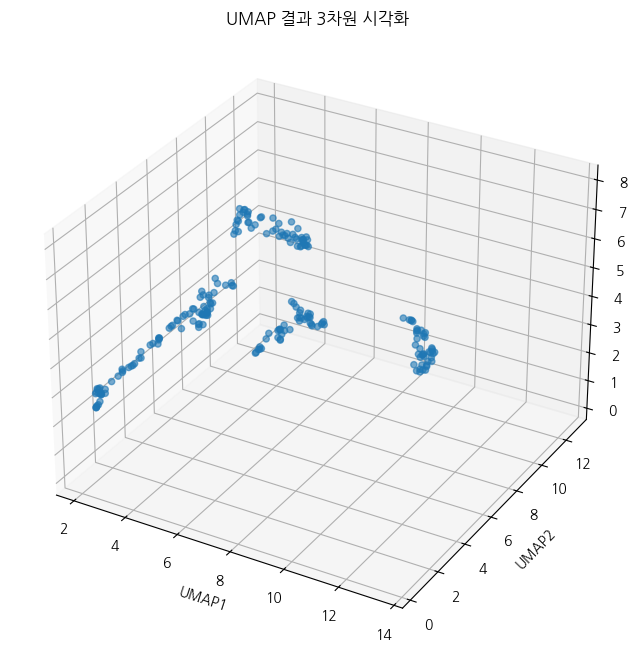

In [70]:
# UMAP을 사용한 차원 축소
umap_reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
data_umap = umap_reducer.fit_transform(data_pca)

# UMAP 결과를 3차원 공간에 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:, 0], data_umap[:, 1], data_umap[:, 2], alpha=0.6)
ax.set_title('UMAP 결과 3차원 시각화')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.show()


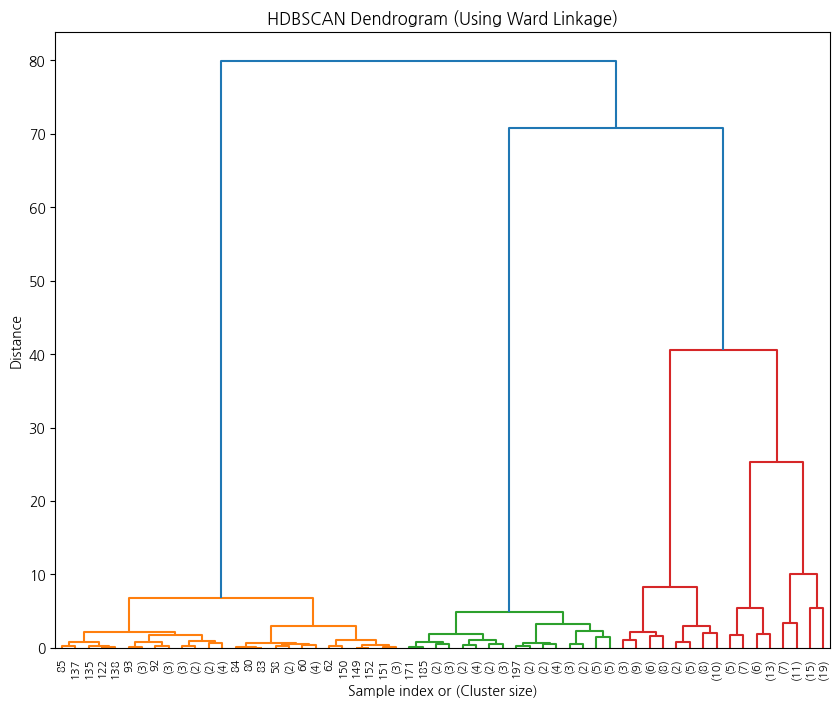

In [71]:
# HDBSCAN의 덴드로그램 시각화를 대신 계층적 클러스터링을 시각화하려면 scipy의 linkage와 dendrogram을 사용할 수 있습니다.
from scipy.cluster.hierarchy import linkage, dendrogram

# HDBSCAN에서 생성된 클러스터의 계층적 구조를 표현하기 위해 linkage matrix 생성
linkage_matrix = linkage(data_umap, method='ward')

# 덴드로그램 시각화
fig, ax = plt.subplots(figsize=(10, 8))
dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=8, truncate_mode='level', p=5, ax=ax)
plt.title('HDBSCAN Dendrogram (Using Ward Linkage)')
plt.xlabel('Sample index or (Cluster size)')
plt.ylabel('Distance')
plt.show()
